<div>
    <div><img src="images/drivendata-logo.svg" alt="drawing" width="100"/></div>
    <br>
    <div><img src="images/nepal-quake-bm-2.jfif" alt="drawing" width="400"/></div>
</div>

## Richter's Predictor: Modeling Earthquake Damage
##### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### Modélisation en considérant les 3 niveaux géographiques comme des catégories, une réduction des dimensions est alors nécessaire


##### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Chargement du fichier et agrégation aux niveaux 1 et 2 et sur la cible (target)

In [1]:
# https://plot.ly/python/treemaps/#treemap-chart-with-a-continuous-colorscale

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np

df_val = pd.read_csv("data/train_values.csv",sep=",",header=0)
df_label = pd.read_csv("data/train_labels.csv",sep=",",header=0)
df=pd.merge(df_val, df_label)[['geo_level_1_id','geo_level_2_id','geo_level_3_id','damage_grade']]
df=df.rename(columns={'geo_level_1_id': 'level_1', 'geo_level_2_id': 'level_2', 'damage_grade': 'target'})
df=df.groupby(['level_1','level_2','target']).agg('count')
df=df.rename(columns={'geo_level_3_id': "nb_rows"})
df=df.reset_index()
df['target_rows']=df['nb_rows']*df['target']

df.nb_rows.sum()

260601

In [19]:
df_label.head()

building_id  damage_grade
0       802906             3
1        28830             2
2        94947             3
3       590882             2
4       201944             3

In [38]:
df_label['damage_grade'].unique()

array([3, 2, 1], dtype=int64)

### Répartion des valeurs des 3 geo_level

##### les valeurs d'un niveau ne sont pas liées à celles du niveau supérieur

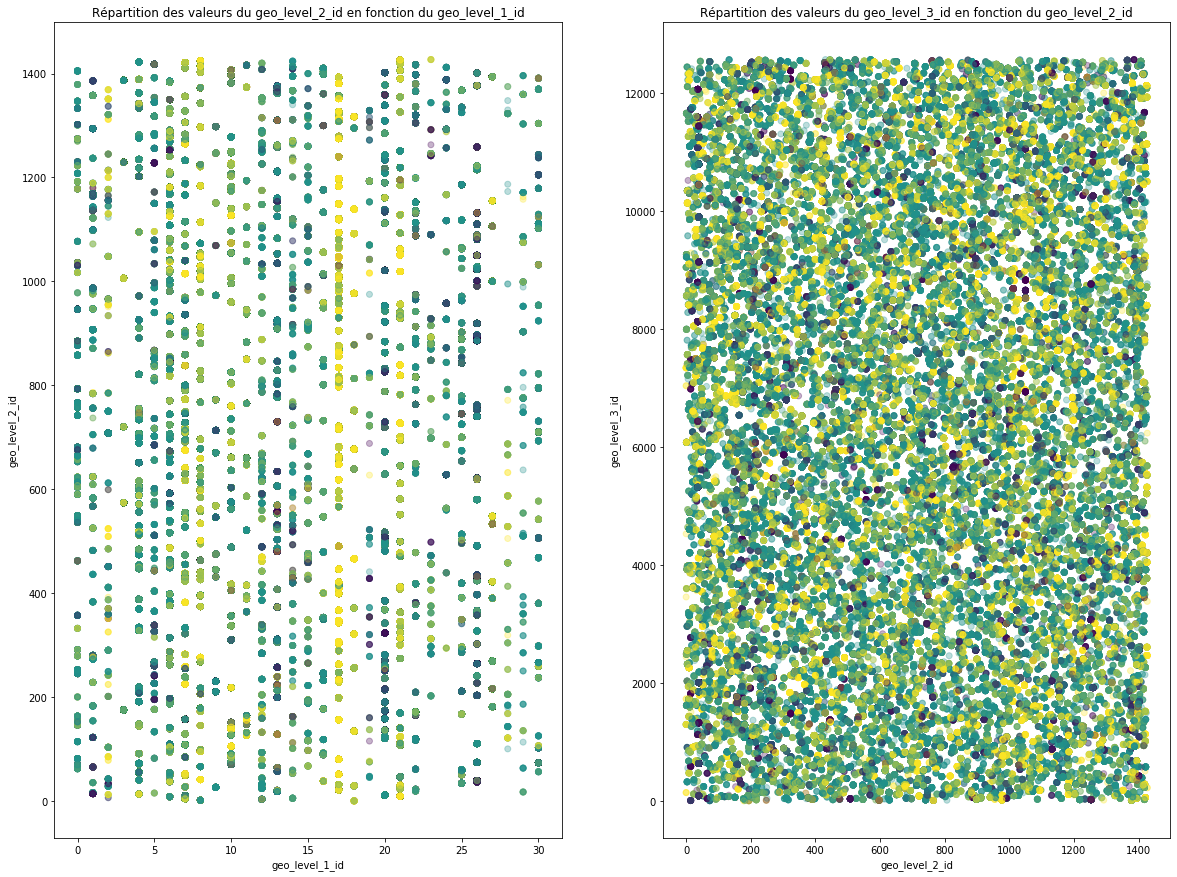

In [41]:
import matplotlib.pyplot as plt

fig = plt.figure(1, figsize=(20, 15))
ax1 = fig.add_subplot(1, 2, 1)
#_=ax.scatter(df['level_1'], df['level_2'], alpha=0.3, c=df_label['damage_grade'])
_=ax1.scatter(df_val['geo_level_1_id'], df_val['geo_level_2_id'], alpha=0.3, c=df_label['damage_grade'])
ax1.set_title('Répartition des valeurs du geo_level_2_id en fonction du geo_level_1_id')
ax1.set_xlabel('geo_level_1_id')
ax1.set_ylabel('geo_level_2_id')
ax2 = fig.add_subplot(1, 2, 2)
#_=ax.scatter(df['level_1'], df['level_2'], alpha=0.3, c=df_label['damage_grade'])
_=ax2.scatter(df_val['geo_level_2_id'], df_val['geo_level_3_id'], alpha=0.3, c=df_label['damage_grade'])
ax2.set_title('Répartition des valeurs du geo_level_3_id en fonction du geo_level_2_id')
ax2.set_xlabel('geo_level_2_id')
ax2.set_ylabel('geo_level_3_id')
plt.show()

### Constitution des dataframes df3 (agrégation geo_level_1) et df4 (agrégation geo_level_2)

In [3]:
df3=df.groupby(['level_1']).agg('sum')
df3=df3.drop(['level_2','target','target_rows'],1)
nb_level1 = df3.shape[0]

df4=df.groupby(['level_2']).agg('sum')
nb_level2 = df4.shape[0]

In [4]:
fig = plt.figure(1, figsize=(10, 6))
_=plt.bar(df3.index, df3['nb_rows'])
_=plt.title('Nb de lignes de chacun des {} geo_level_1'.format(nb_level1))
plt.plot([5000]*nb_level1, c='orange')
plt.plot([1000]*nb_level1, c='red')
plt.show()


<Figure size 1000x600 with 1 Axes>

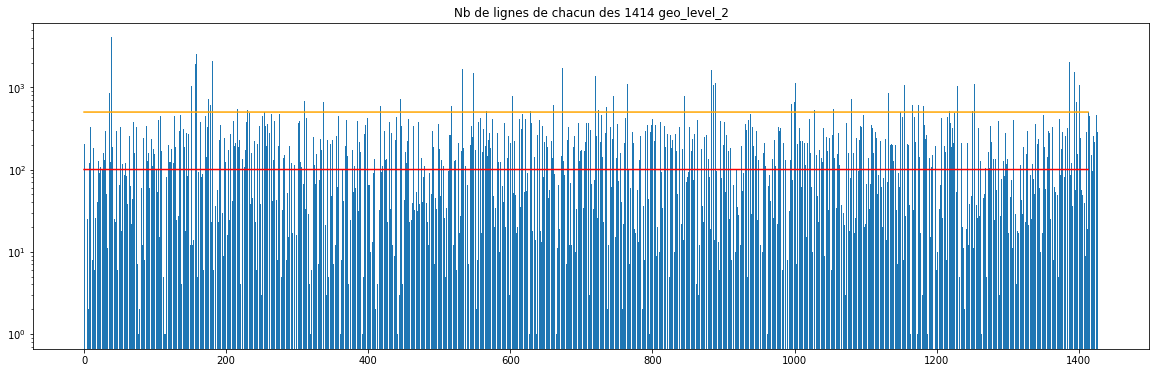

In [5]:
fig = plt.figure(1, figsize=(20, 6))
_=plt.bar(df4.index, df4['nb_rows'])
_=plt.title('Nb de lignes de chacun des {} geo_level_2'.format(nb_level2))
plt.yscale('log')
plt.plot([500]*nb_level2, c='orange')
plt.plot([100]*nb_level2, c='red')
plt.show()

### Analyse du niveau 1

In [42]:
df1=df.groupby(['level_1','target']).agg('sum')
df1=df1.drop(['level_2','target_rows'],1)
df2=df1.unstack('target')

fig = make_subplots(rows=1, cols=2, column_widths=[0.3, 0.7],
                    specs=[[{"type": "xy"},{"type": "xy"}]],
                    subplot_titles=("Global","Par target"),
                    shared_yaxes=True)

fig.add_trace(go.Heatmap(
                   z=df3.values,
                   y=df3.index,
                   x=['Total'],
                   colorscale='Viridis',
                   hoverongaps = False),
              row=1, col=1)

fig.add_trace(go.Heatmap(
                   z=df2['nb_rows'].values,
                   y=df2['nb_rows'].index,
                   x=['Target 1', 'Target 2', 'Target 3'],
                   colorscale='Viridis',
                   hoverongaps = False),
              row=1, col=2)
fig.update_layout(
     width = 900, height = 700,
    title='HEAT MAP : Niveau 1')
fig.show()

### Analyse du niveau 2

In [43]:
levels = ['level_2', 'level_1'] # levels used for the hierarchical chart
level = ['level_1']
color_columns = ['target_rows', 'nb_rows']
value_column = 'nb_rows'

def build_hierarchical_dataframe(df, levels, value_column, color_columns=None):
    """
    Build a hierarchy of levels for Sunburst or Treemap charts.

    Levels are given starting from the bottom to the top of the hierarchy, 
    ie the last level corresponds to the root.
    """
    df_all_trees = pd.DataFrame(columns=['id', 'parent', 'value', 'color'])
    for i, level in enumerate(levels):
        df_tree = pd.DataFrame(columns=['id', 'parent', 'value', 'color'])
        dfg = df.groupby(levels[i:]).sum(numerical_only=True)
        dfg = dfg.reset_index()
        df_tree['id'] = dfg[level].copy()
        if i < len(levels) - 1:
            df_tree['parent'] = dfg[levels[i+1]].copy()
        else:
            df_tree['parent'] = 'total'
        df_tree['value'] = dfg[value_column]
        df_tree['color'] = dfg[color_columns[0]]/dfg[color_columns[1]]
        df_all_trees = df_all_trees.append(df_tree, ignore_index=True)
    total = pd.Series(dict(id='total', parent='', 
                              value=df[value_column].sum(),
                              color=df[color_columns[0]].sum() / df[color_columns[1]].sum()))
    df_all_trees = df_all_trees.append(total, ignore_index=True)
    return df_all_trees

#### Le treemap ne s'affche pas si nous avons trop de cellules à aficher
#### Une limitation est placée en fonction du nb_rows du level2

In [44]:
limit=329
df[df['nb_rows']>limit].sum()

level_1          2046
level_2         91523
target            295
nb_rows         70939
target_rows    153070
dtype: int64

In [45]:
df_limited=df[df['nb_rows']>limit]
df_all_trees = build_hierarchical_dataframe(df_limited, levels, value_column, color_columns)
average_score = df['target'].sum() / df['nb_rows'].count()
df_all_trees.shape

(124, 4)

In [46]:
df_one_level = build_hierarchical_dataframe(df, level, value_column, color_columns)
average_score = df['target'].sum() / df['nb_rows'].count()
df_one_level.shape

(32, 4)

In [47]:
fig = make_subplots(2, 1, specs=[[{"type": "domain"}],[{"type": "domain"}]],\
                    subplot_titles=['Population totale de niveau 1\nsoit {0} niveaux 1 et {1} rows'\
                                    .format(df_one_level.shape[0]-1, df['nb_rows'].sum()),\
                    'Détail avec limitation à {0} lignes minimum\nsoit {1} niveaux 1 représentés et {2} rows'\
                                    .format(limit,df_all_trees.groupby('parent').count().shape[0]-2, df_all_trees[df_all_trees['id']=='total']['value'].values[0])],\
                   vertical_spacing=0.1)

fig.add_trace(go.Treemap(
    labels=df_one_level['id'],
    parents=df_one_level['parent'],
    values=df_one_level['value'],
    branchvalues='total',
    marker=dict(
        colors=df_all_trees['color'],
        colorscale='Magma',
        cmid=average_score),
    hovertemplate='<b>%{label} </b> <br> Nb rows: %{value}<br> Target moyenne: %{color:.2f}',
    #maxdepth=2
    name=''
    ), 1, 1)

fig.add_trace(go.Treemap(
    labels=df_all_trees['id'],
    parents=df_all_trees['parent'],
    values=df_all_trees['value'],
    branchvalues='total',
    marker=dict(
        colors=df_all_trees['color'],
        colorscale='Magma',
        cmid=average_score),
    hovertemplate='<b>%{label} </b> <br> Nb rows: %{value}<br> Target moyenne: %{color:.2f}',
    #maxdepth=2
    name=''
    ), 2, 1)

fig.update_layout(height=900, width=900, title_text='Représentation du fichier pour les niveaux 1 et 2')
fig.show()

#### liste des 19 niveaux représentés

In [48]:
list_level_1_limited=list(df_all_trees.groupby('parent').count().reset_index()['parent'])[:-2]
print(list_level_1_limited)

[0, 1, 3, 4, 6, 7, 8, 9, 10, 11, 17, 20, 21, 22, 24, 25, 26, 27, 30]


In [49]:
df_all_trees[df_all_trees['id']=='total']['value'].values[0]

70939

In [50]:
mask = np.logical_not(df['level_1'].isin(list_level_1_limited))
df_mask=df[mask]
limit_other=147
df_other=df_mask[df_mask['nb_rows']>limit_other]

In [51]:
df_other_trees = build_hierarchical_dataframe(df_other, levels, value_column, color_columns)
average_score = df_other['target'].sum() / df_other['nb_rows'].count()
df_other_trees.shape

(34, 4)

In [52]:
df_one_level_other = build_hierarchical_dataframe(df_mask, level, value_column, color_columns)
average_score = df_mask['target'].sum() / df_mask['nb_rows'].count()
df_one_level_other.shape

(13, 4)

In [53]:
fig = make_subplots(2, 1, specs=[[{"type": "domain"}],[{"type": "domain"}]],\
                    subplot_titles=['Population totale de niveau 1\nsoit {0} niveaux 1 et {1} rows'\
                                    .format(df_one_level_other.shape[0]-1, df_mask['nb_rows'].sum()),\
                    'Détail avec limitation à {0} lignes minimum\nsoit {1} niveaux 1 représentés et {2} rows'\
                                    .format(limit_other,df_other_trees.groupby('parent').count().shape[0]-2, df_other_trees[df_other_trees['id']=='total']['value'].values[0])],\
                   vertical_spacing=0.1)

fig.add_trace(go.Treemap(
    labels=df_one_level_other['id'],
    parents=df_one_level_other['parent'],
    values=df_one_level_other['value'],
    branchvalues='total',
    marker=dict(
        colors=df_one_level_other['color'],
        colorscale='Magma',
        cmid=average_score),
    hovertemplate='<b>%{label} </b> <br> Nb rows: %{value}<br> Target moyenne: %{color:.2f}',
    #maxdepth=2
    name=''
    ), 1, 1)

fig.add_trace(go.Treemap(
    labels=df_other_trees['id'],
    parents=df_other_trees['parent'],
    values=df_other_trees['value'],
    branchvalues='total',
    marker=dict(
        colors=df_other_trees['color'],
        colorscale='Magma',
        cmid=average_score),
    hovertemplate='<b>%{label} </b> <br> Nb rows: %{value}<br> Target moyenne: %{color:.2f}',
    #maxdepth=2
    name=''
    ), 2, 1)

fig.update_layout(height=900, width=900, title_text='Zoom sur les niveaux 1 non représentés précédemment')
fig.show()

##### fonction limit_level_1 : réduction du niveau 1

In [54]:
def limit_level_1(data, limit):
    mask=data['geo_level_1_id'].isin(df3[df3.nb_rows>limit].index)
    data['geo_level_3_id'].where(mask, 99999,inplace=True)
    data['geo_level_2_id'].where(mask, 9999,inplace=True)
    data['geo_level_1_id'].where(mask, 999,inplace=True)
    return data

##### fonction limit_level_2 : réduction du niveau 2

In [55]:
def limit_level_2(data, limit):
    mask=data['geo_level_2_id'].isin(df4[df4.nb_rows>limit].index)
    data['geo_level_3_id'].where(mask, 99999,inplace=True)
    data['geo_level_2_id'].where(mask, 9999,inplace=True)
    return data

In [72]:
limit_2=2000
limit_3=500
df_val2=limit_level_1(df_val, limit_2)
df_val3=limit_level_2(df_val2, limit_3)

In [73]:
print('Nombre de niveau 1 initiaux : {}'
      .format(df_val.groupby(['geo_level_1_id']).count().shape[0]))
print('Nombre de niveau 2 initiaux : {}'
      .format(df_val.groupby(['geo_level_2_id']).count().shape[0]))
print('Nombre de niveau 3 initiaux : {}'
      .format(df_val.groupby(['geo_level_3_id']).count().shape[0]))
print('\n*****************************************************************************')
print('\nNombre de niveau 1 après réduction à {} lignes minimum : {}'
      .format(limit_2, df_val2.groupby(['geo_level_1_id']).count().shape[0]))
print('Nombre de lignes à niveau 1 = 999 : {}'
     .format(df_val2[df_val2['geo_level_1_id']==999].shape[0]))
print('\nNombre de niveau 2 après traitement : {}'
      .format(df_val2.groupby(['geo_level_2_id']).count().shape[0]))
print('Nombre de niveau 3 après traitement : {}'
      .format(df_val2.groupby(['geo_level_3_id']).count().shape[0]))
print('\n*****************************************************************************')
print('Nombre de lignes à niveau 2 = 9999 : {}'
     .format(df_val3[df_val3['geo_level_2_id']==9999].shape[0]))
print('Nombre de niveau 2 après réduction à {} lignes minimum : {}'
      .format(limit_3, df_val3.groupby(['geo_level_2_id']).count().shape[0]))
print('Nombre de niveau 3 après traitement : {}'
      .format(df_val3.groupby(['geo_level_3_id']).count().shape[0]))

Nombre de niveau 1 initiaux : 25
Nombre de niveau 2 initiaux : 76
Nombre de niveau 3 initiaux : 923

*****************************************************************************

Nombre de niveau 1 après réduction à 2000 lignes minimum : 25
Nombre de lignes à niveau 1 = 999 : 6109

Nombre de niveau 2 après traitement : 76
Nombre de niveau 3 après traitement : 923

*****************************************************************************
Nombre de lignes à niveau 2 = 9999 : 188056
Nombre de niveau 2 après réduction à 500 lignes minimum : 76
Nombre de niveau 3 après traitement : 923


In [74]:
df_val2.head(10)

building_id  geo_level_1_id  geo_level_2_id  geo_level_3_id  \
0       802906               6            9999           99999   
1        28830               8            9999           99999   
2        94947              21             363            8973   
3       590882              22            9999           99999   
4       201944              11             131            1488   
5       333020               8            9999           99999   
6       728451               9            9999           99999   
7       475515              20            9999           99999   
8       441126               0            9999           99999   
9       989500              26             886             994   

   count_floors_pre_eq  age  area_percentage  height_percentage  \
0                    2   30                6                  5   
1                    2   10                8                  7   
2                    2   10                5                  5   
3                    2   10                6                  5   
4                    3   30                8                  9   
5                    2   10                9                  5   
6                    2   25                3                  4   
7                    2    0                8                  6   
8                    2   15                8                  6   
9                    1    0               13                  4   

  land_surface_condition foundation_type  ... has_secondary_use_agriculture  \
0                      t               r  ...                             0   
1                      o               r  ...                             0   
2                      t               r  ...                             0   
3                      t               r  ...                             0   
4                      t               r  ...                             0   
5                      t               r  ...                             1   
6                      n               r  ...                             0   
7                      t               w  ...                             0   
8                      t               r  ...                             0   
9                      t               i  ...                             0   

  has_secondary_use_hotel has_secondary_use_rental  \
0                       0                        0   
1                       0                        0   
2                       0                        0   
3                       0                        0   
4                       0                        0   
5                       0                        0   
6                       0                        0   
7                       0                        0   
8                       0                        0   
9                       0                        0   

  has_secondary_use_institution has_secondary_use_school  \
0                             0                        0   
1                             0                        0   
2                             0                        0   
3                             0                        0   
4                             0                        0   
5                             0                        0   
6                             0                        0   
7                             0                        0   
8                             0                        0   
9                             0                        0   

   has_secondary_use_industry  has_secondary_use_health_post  \
0                           0                              0   
1                           0                              0   
2                           0                              0   
3                           0                              0   
4                           0                              0   
5                           

In [75]:
df_val3.head(10)

building_id  geo_level_1_id  geo_level_2_id  geo_level_3_id  \
0       802906               6            9999           99999   
1        28830               8            9999           99999   
2        94947              21             363            8973   
3       590882              22            9999           99999   
4       201944              11             131            1488   
5       333020               8            9999           99999   
6       728451               9            9999           99999   
7       475515              20            9999           99999   
8       441126               0            9999           99999   
9       989500              26             886             994   

   count_floors_pre_eq  age  area_percentage  height_percentage  \
0                    2   30                6                  5   
1                    2   10                8                  7   
2                    2   10                5                  5   
3                    2   10                6                  5   
4                    3   30                8                  9   
5                    2   10                9                  5   
6                    2   25                3                  4   
7                    2    0                8                  6   
8                    2   15                8                  6   
9                    1    0               13                  4   

  land_surface_condition foundation_type  ... has_secondary_use_agriculture  \
0                      t               r  ...                             0   
1                      o               r  ...                             0   
2                      t               r  ...                             0   
3                      t               r  ...                             0   
4                      t               r  ...                             0   
5                      t               r  ...                             1   
6                      n               r  ...                             0   
7                      t               w  ...                             0   
8                      t               r  ...                             0   
9                      t               i  ...                             0   

  has_secondary_use_hotel has_secondary_use_rental  \
0                       0                        0   
1                       0                        0   
2                       0                        0   
3                       0                        0   
4                       0                        0   
5                       0                        0   
6                       0                        0   
7                       0                        0   
8                       0                        0   
9                       0                        0   

  has_secondary_use_institution has_secondary_use_school  \
0                             0                        0   
1                             0                        0   
2                             0                        0   
3                             0                        0   
4                             0                        0   
5                             0                        0   
6                             0                        0   
7                             0                        0   
8                             0                        0   
9                             0                        0   

   has_secondary_use_industry  has_secondary_use_health_post  \
0                           0                              0   
1                           0                              0   
2                           0                              0   
3                           0                              0   
4                           0                              0   
5                           

##### sauvegarde en csv du dataframe réduit : df_val3

In [76]:
df_val3.to_csv("data/train_values_99.csv",sep=",",header=True, index=False)

##### rechargement data et labels à partir des fichiers externes

In [77]:
file_values_name="data/train_values_99.csv"
file_target_name="data/train_labels.csv"

data = pd.read_csv(file_values_name,sep=",",header=0)
labels = pd.read_csv(file_target_name,sep=",",header=0)

##### Catégorisation des colonnes : fonction categorized

In [78]:
def categorized(data):
    data_columns_bool=['has_superstructure_adobe_mud','has_superstructure_mud_mortar_stone','has_superstructure_stone_flag',\
        'has_superstructure_cement_mortar_stone', 'has_superstructure_mud_mortar_brick','has_superstructure_cement_mortar_brick',\
        'has_superstructure_timber','has_superstructure_bamboo',\
        'has_superstructure_rc_non_engineered','has_superstructure_rc_engineered','has_superstructure_other',
        'has_secondary_use', 'has_secondary_use_agriculture', 'has_secondary_use_hotel', 'has_secondary_use_rental',\
        'has_secondary_use_institution', 'has_secondary_use_school', 'has_secondary_use_industry', 'has_secondary_use_health_post',\
        'has_secondary_use_gov_office', 'has_secondary_use_use_police', 'has_secondary_use_other']
    data[data_columns_bool]=data[data_columns_bool].astype(bool)
    data_columns_category=['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',\
        'land_surface_condition','foundation_type','roof_type','ground_floor_type','other_floor_type','position',\
        'plan_configuration', 'legal_ownership_status']
    data[data_columns_category]=data[data_columns_category].astype('category')
    return data

In [79]:
data=categorized(data)

#### application d'un MinMaxScaler : fonction scalered

In [80]:
from sklearn.preprocessing import MinMaxScaler

def scalered(data, columns):
    scaler = MinMaxScaler()
    data_scaler=scaler.fit_transform(data[columns])
    data_scaled=data
    data_scaled[data_columns_integer]=data_scaler
    return data_scaled

In [81]:
data_columns_integer=['count_floors_pre_eq','age','area_percentage','height_percentage', 'count_families']
data_scaled=scalered(data, data_columns_integer)
print(data_scaled[data_columns_integer].head())
print('\n')
data_scaled.info()

   count_floors_pre_eq       age  area_percentage  height_percentage  \
0                0.125  0.030151         0.050505           0.100000   
1                0.125  0.010050         0.070707           0.166667   
2                0.125  0.010050         0.040404           0.100000   
3                0.125  0.010050         0.050505           0.100000   
4                0.250  0.030151         0.070707           0.233333   

   count_families  
0        0.111111  
1        0.111111  
2        0.111111  
3        0.111111  
4        0.111111  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 39 columns):
building_id                               260601 non-null int64
geo_level_1_id                            260601 non-null category
geo_level_2_id                            260601 non-null category
geo_level_3_id                            260601 non-null category
count_floors_pre_eq                       260601 non-null float64
age

##### Drop de geo_level_3_id et Get_dummies : fonction drop_dummies

In [82]:
def drop_dummies(data):
    data_0 = data.drop('geo_level_3_id', axis=1)
    return pd.get_dummies(data_0)

In [83]:
data_scaled_l1_l2_extended = drop_dummies(data_scaled)
print("Shape après get_dummies l1 et l2 : {}".format(str(data_scaled_l1_l2_extended.shape)))
data_scaled_l1_l2_extended.info()

Shape après get_dummies l1 et l2 : (260601, 167)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Columns: 167 entries, building_id to legal_ownership_status_w
dtypes: bool(22), float64(5), int64(1), uint8(139)
memory usage: 51.9 MB


## Construction des modèles

#### Constitution bases d'entraînement et base de test

In [84]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_scaled_l1_l2_extended, labels.damage_grade, stratify=labels.damage_grade, random_state=94)

##### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### Modèle DecisionTreeClassifier : tree

In [85]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=94)
tree.fit(X_train, y_train)
print('DecisionTreeClassifier - Précision sur entraînement : {:.3f}'.format(tree.score(X_train, y_train)))
print('DecisionTreeClassifier - Précision sur test : {:.3f}'.format(tree.score(X_test, y_test)))

DecisionTreeClassifier - Précision sur entraînement : 1.000
DecisionTreeClassifier - Précision sur test : 0.601


#### Modèle RandomForestClassifier : forest

In [86]:
from sklearn.ensemble import RandomForestClassifier

n_estimators=100

forest = RandomForestClassifier(n_estimators=n_estimators, random_state = 94)
forest.fit(X_train, y_train)
print("RandomForestClassifier - Précision entraînement {} Estimateurs : {:.3f}".format(n_estimators, forest.score(X_train, y_train)))
print("RandomForestClassifier - Précision test Profondeur {} Estimateurs : {:.3f}".format(n_estimators, forest.score(X_test, y_test)))

RandomForestClassifier - Précision entraînement 100 Estimateurs : 1.000
RandomForestClassifier - Précision test Profondeur 100 Estimateurs : 0.688


##### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#### Modèle GradientBoostingClassifier : gbrt_3

In [200]:
from sklearn.ensemble import GradientBoostingClassifier

In [202]:
gbrt_3 = GradientBoostingClassifier(random_state=94)
gbrt_3.fit(X_train, y_train)
print("GradientBoostingClassifier - Précision entraînement : {:.3f}".format(gbrt_3.score(X_train, y_train)))
print("GradientBoostingClassifier - Précision test : {:.3f}".format(gbrt_3.score(X_test, y_test)))

GradientBoostingClassifier - Précision entraînement : 0.682
GradientBoostingClassifier - Précision test : 0.682


#### Modèle GradientBoostingClassifier max_depth = 1 : gbrt_1

In [32]:
gbrt_1 = GradientBoostingClassifier(random_state=94, max_depth=1)
gbrt_1.fit(X_train, y_train)
print("GradientBoostingClassifier max_depth=1 - Précision entraînement : {:.3f}".format(gbrt_1.score(X_train, y_train)))
print("GradientBoostingClassifier max_depth=1 - Précision test : {:.3f}".format(gbrt_1.score(X_test, y_test)))

GradientBoostingClassifier max_depth=1 - Précision entraînement : 0.658
GradientBoostingClassifier max_depth=1 - Précision test : 0.659


#### Modèle GradientBoostingClassifier max_depth = 5 : gbrt_5

In [33]:
gbrt_5 = GradientBoostingClassifier(random_state=94, max_depth=5)
gbrt_5.fit(X_train, y_train)
print("GradientBoostingClassifier max_depth=5 - Précision entraînement : {:.3f}".format(gbrt_5.score(X_train, y_train)))
print("GradientBoostingClassifier max_depth=5 - Précision test : {:.3f}".format(gbrt_5.score(X_test, y_test)))

GradientBoostingClassifier max_depth=5 - Précision entraînement : 0.711
GradientBoostingClassifier max_depth=5 - Précision test : 0.706


#### Modèle GradientBoostingClassifier max_depth = 10 n_estimators = 200 : gbrt_10_200

In [60]:
gbrt_10_200 = GradientBoostingClassifier(random_state=94, max_depth=10, n_estimators=200)
gbrt_10_200.fit(X_train, y_train)
print("GradientBoostingClassifier max_depth=10 n_estimators=200 - Précision entraînement : {:.3f}".format(gbrt_10_200.score(X_train, y_train)))
print("GradientBoostingClassifier max_depth=10 n_estimators=200 - Précision test : {:.3f}".format(gbrt_10_200.score(X_test, y_test)))


GradientBoostingClassifier max_depth=10 n_estimators=200 - Précision entraînement : 0.792
GradientBoostingClassifier max_depth=10 n_estimators=200 - Précision test : 0.720


##### Modèle GradientBoostingClassifier max_depth = 15 n_estimators = 100 : gbrt_15_100

In [64]:
gbrt_15_100 = GradientBoostingClassifier(random_state=94, max_depth=15, n_estimators=100)
gbrt_15_100.fit(X_train, y_train)
print("GradientBoostingClassifier max_depth=10 n_estimators=200 - Précision entraînement : {:.3f}".format(gbrt_15_100.score(X_train, y_train)))
print("GradientBoostingClassifier max_depth=10 n_estimators=200 - Précision test : {:.3f}".format(gbrt_15_100.score(X_test, y_test)))


GradientBoostingClassifier max_depth=10 n_estimators=200 - Précision entraînement : 0.850
GradientBoostingClassifier max_depth=10 n_estimators=200 - Précision test : 0.717


#### Modèle GradientBoostingClassifier learning_rate = 0.01 : gbrt_lr001

In [34]:
gbrt_lr001 = GradientBoostingClassifier(random_state=94, learning_rate=0.01)
gbrt_lr001.fit(X_train, y_train)
print("GradientBoostingClassifier learning_rate=0.01 - Précision entraînement : {:.3f}".format(gbrt_lr001.score(X_train, y_train)))
print("GradientBoostingClassifier learning_rate=0.01 - Précision test : {:.3f}".format(gbrt_lr001.score(X_test, y_test)))

GradientBoostingClassifier learning_rate=0.01 - Précision entraînement : 0.623
GradientBoostingClassifier learning_rate=0.01 - Précision test : 0.625


##### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

#### Modèle LogisticRegression en cross validation

In [87]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

scores = cross_val_score(LogisticRegression(solver='liblinear', multi_class='ovr'), X_train, y_train, cv=5)
print("LogisticRegression - Précision moyenne de la cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Précision moyenne de la cross-validation accuracy: 0.57


#### Modèle LogisticRegression avec GridSearch : grid

In [88]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(solver='liblinear', multi_class='ovr'), param_grid, cv=5)
grid.fit(X_train, y_train)
print("LogisticRegression - Meilleur score de la cross-validation : {:.2f}".format(grid.best_score_))
print("LogisticRegression - Meilleurs parametres: ", grid.best_params_)

Meilleur score de la cross-validation : 0.57
Meilleurs parametres:  {'C': 0.001}


In [89]:
print("LogisticRegression - Score : {:.3f}".format(grid.score(X_test, y_test)))

LogisticRegression - Score : 0.569


#### Modèle Bayésien naïf - GaussianNB : clf

In [90]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X_train, y_train)
print('Bayésien naïf - GaussianNB - Précision sur entraînement : {:.3f}'.format(clf.score(X_train, y_train)))
print('Bayésien naïf - GaussianNB - Précision sur test : {:.3f}'.format(clf.score(X_test, y_test)))

Bayésien naïf - GaussianNB - Précision sur entraînement : 0.569
Bayésien naïf - GaussianNB - Précision sur test : 0.569


##### ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Traitement du fichier de test à soumettre

In [39]:
df_test_values = pd.read_csv("data/test_values.csv",sep=",",header=0)

print('Shape du fichier de tests : {}'.format(df_test_values.shape))

Shape du fichier de tests : (86868, 39)


In [42]:
df_val2=limit_level_1(df_test_values, limit_2)
df_val3=limit_level_2(df_val2, limit_3)

submission=categorized(df_test_values)
submission=scalered(submission, data_columns_integer)
submission=drop_dummies(submission)

In [65]:
df_to_submission = pd.DataFrame(gbrt_15_100.predict(submission))

In [66]:
df_to_submission.set_index(df_test_values['building_id'], inplace=True)
df_to_submission.rename(columns={0: "damage_grade"}, inplace=True)

In [67]:
df_to_submission.to_csv("data/test_values_submission.csv",sep=",")